<a href="https://colab.research.google.com/github/Kush-Singh-26/Learning-Pytorch/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
import torch
import numpy as np
import cv2


In [2]:
np.random.seed(20)

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

In [9]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.ToTensor()
  img = transform(img)

  pred = model([img])

  pred_data = pred[0]

  labels = pred_data['labels'].detach().cpu().numpy()
  boxes = pred_data['boxes'].detach().cpu().numpy()
  scores = pred_data['scores'].detach().cpu().numpy()

  valid_indices = scores > threshold

  pred_boxes = [((b[0], b[1]), (b[2], b[3])) for b in boxes[valid_indices]]
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]

  return pred_boxes, pred_class

In [11]:
def object_detection(img_path, threshold):
  boxes, pred_cls = get_prediction(img_path, threshold)

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)   #thickness for drawing bounding boxes based on image size
  text_th = max(rect_th - 1, 1) # annotation thickness

  for i in range(len(boxes)):
     # Extract bounding box coordinates from the prediction output
    p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

    color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

    cv2.rectangle(
        img,
        p1, # top left corner
        p2, # bottom right corner
        color = color, # bbox color
        thickness=rect_th # line thickness
    )

    w, h = cv2.getTextSize(
            pred_cls[i],  # Object class name
            0,  # Font face
            fontScale=rect_th / 3,  # Scale font relative to box thickness
            thickness=text_th  # Text thickness
        )[0]

    # Determine if text label should be placed inside or outside the bounding box
    outside = p1[1] - h >= 3  # Check if there is enough space to put text above the box
    # Calculate coordinates for the background rectangle that holds the text
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

    cv2.rectangle(
        img,
        p1,
        p2,
        color=color,
        thickness=-1, # Draw a filled rectangle for the class label background
        lineType=cv2.LINE_AA
    )

    cv2.putText(
            img,
            pred_cls[i],  # Class name
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),  # Adjust text position
            cv2.FONT_HERSHEY_SIMPLEX,  # Font type
            rect_th / 3,  # Scale font size
            (255, 255, 255),  # White text color
            thickness=text_th + 1  # Text thickness
        )
  plt.figure(figsize=(15,12))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

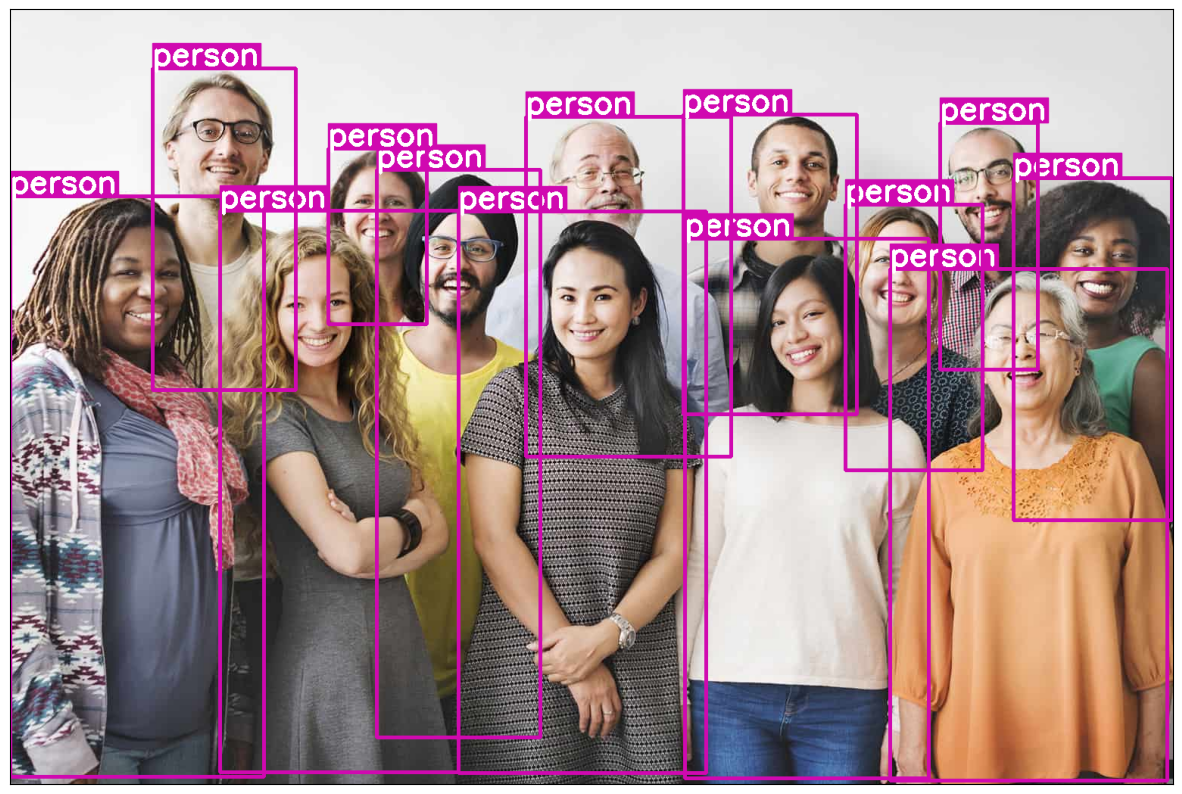

In [12]:
object_detection('people.jpg', threshold=0.8)

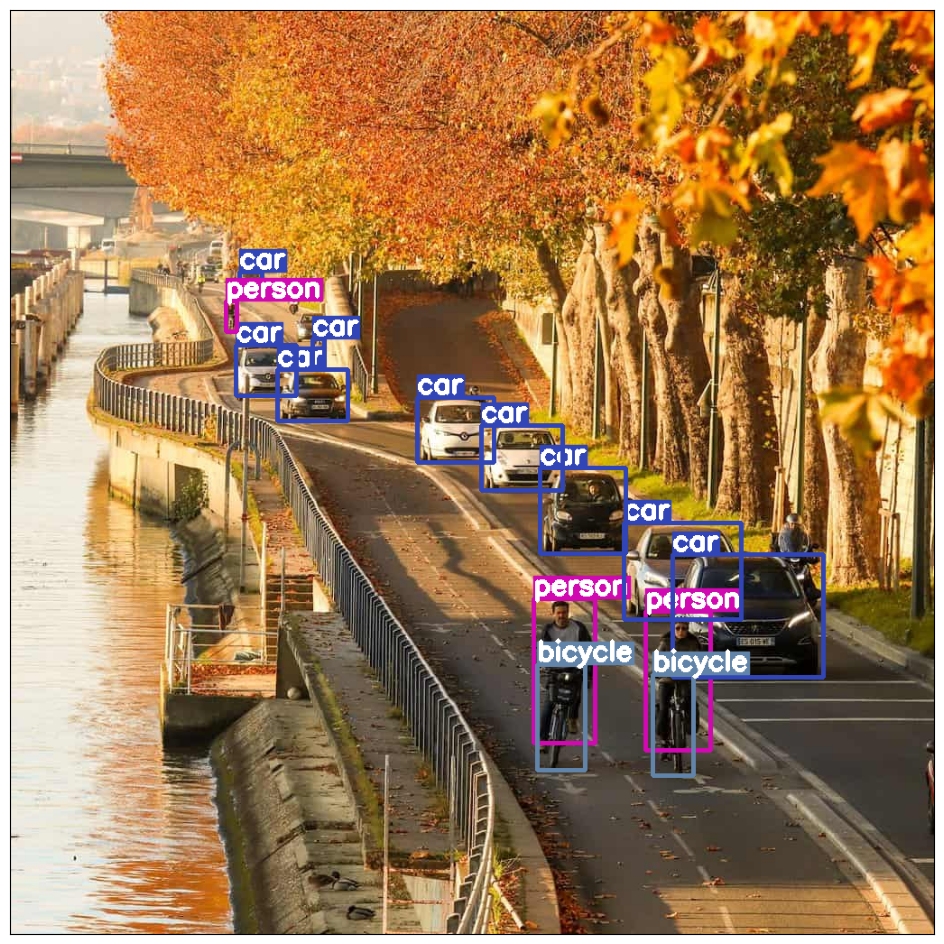

In [13]:
object_detection('vehicles.jpg', threshold=0.8)

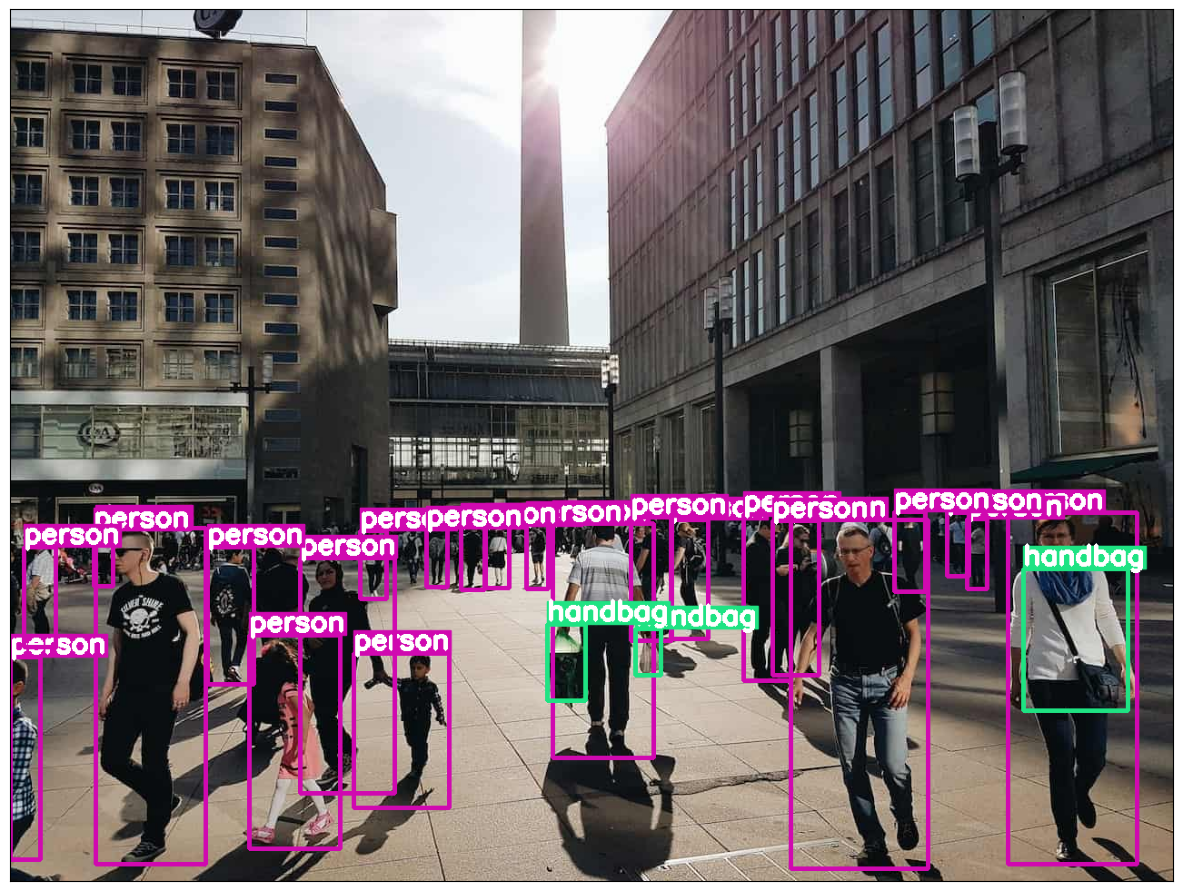

In [14]:
object_detection('crowd.jpg', threshold=0.8)

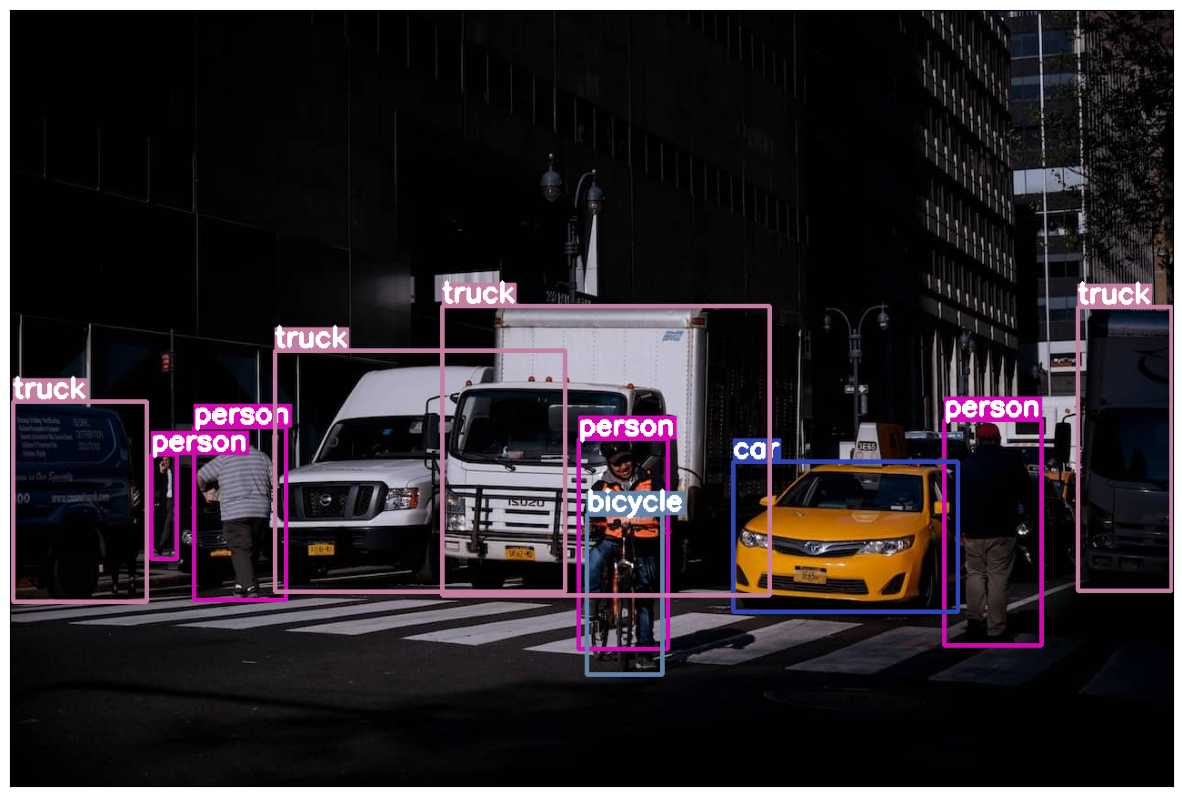

In [15]:
object_detection('night-time.jpg', threshold=0.8)

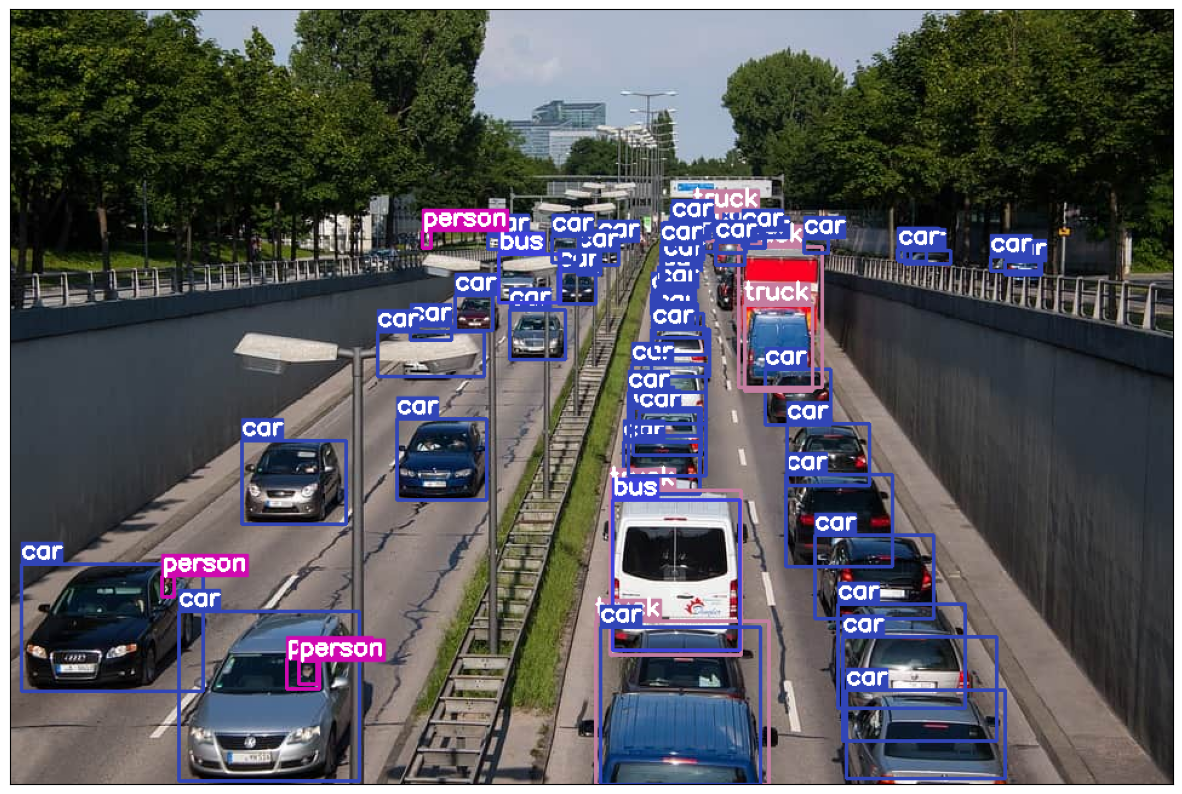

In [17]:
object_detection('traffic_scene.jpg', threshold=0.3)